# 🏥 Project HeartGuard: Phase 1 - The Core Engine

**Anomaly Detection in Temporal Health Data**

Objective: Before building the mobile application or cloud infrastructure, we must engineer the "Heart" of the system. Unlike our previous OCR task which dealt with Spatial data (static images), this project deals with Temporal data (Time Series).

The Challenge: Context matters. A heart rate of 120 BPM is perfectly normal if the user is jogging, but potentially fatal if they are sleeping. A simple threshold model cannot distinguish this. We need a model that understands Time.

**Phase 1 Goals:**

1.   Data Simulation: Create a realistic physiological dataset (Circadian rhythms, activity, noise, and anomalies).
2.   Temporal Engineering: Transform raw data into "Sliding Windows" suitable for an LSTM (Long Short-Term Memory) network.
3.   Tensor Preparation: specific data structures required for PyTorch training.

# Part 1: Simulating the Patient (Data Engineering)

Since real-time medical API access (Fitbit/Apple Health) takes time to configure, we will procedurally generate a patient's heart rate profile.

We will simulate 7 Days of data (minute-by-minute) including:



*   Circadian Rhythm: Lower heart rate during sleep, higher during the day.
*   Activity: Random spikes representing walking or jogging.
*   Noise: Sensor imperfections.
*   Anomalies: Specific "health events" (Sudden Tachycardia/Spikes) that we want our AI to detect.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

def generate_health_data(days=7):
    """
    Generates synthetic heart rate data with daily patterns, activity, and anomalies.
    """
    minutes = days * 24 * 60
    timeline = pd.date_range(start='2024-01-01', periods=minutes, freq='T')

    # 1. Base Heart Rate (Circadian Rhythm)
    # Uses a Sine wave to simulate sleep (low) vs wake (high) cycles
    x = np.linspace(0, days * 2 * np.pi, minutes)
    base_hr = 70 + 10 * np.sin(x)  # Swings between 60 and 80 BPM baseline

    # 2. Add Random Noise (Natural Heart Rate Variability + Sensor Noise)
    noise = np.random.normal(0, 5, minutes)

    # 3. Add Activity Spikes (Random exercise events)
    activity = np.zeros(minutes)
    for _ in range(days * 2): # Approx 2 workouts a day
        start = np.random.randint(0, minutes - 60)
        duration = np.random.randint(30, 60)
        activity[start:start+duration] += np.random.randint(30, 50) # +30-50 BPM spike

    # Combine components
    final_hr = base_hr + noise + activity

    # 4. Inject ANOMALIES (The "Targets" for our AI)
    # Scenario: Sudden extreme spike (Panic/AFib)
    labels = np.zeros(minutes) # 0 = Normal, 1 = Anomaly

    # Inject 5 distinct anomalies at random times
    indices = np.random.choice(range(minutes), 5, replace=False)
    for idx in indices:
        final_hr[idx:idx+15] = 160 # Dangerous Spike to 160+
        labels[idx:idx+15] = 1     # Mark these rows as Anomalies

    df = pd.DataFrame({
        'Timestamp': timeline,
        'Heart_Rate': final_hr,
        'Label': labels
    })

    return df

# Generate the data
df = generate_health_data()

# Save for future use
df.to_csv('health_data.csv', index=False)

print(f"Data Generated: {len(df)} minutes of data.")
print(df.head())

Data Generated: 10080 minutes of data.
            Timestamp  Heart_Rate  Label
0 2024-01-01 00:00:00   72.483571    0.0
1 2024-01-01 00:01:00   69.352316    0.0
2 2024-01-01 00:02:00   73.325717    0.0
3 2024-01-01 00:03:00   77.746058    0.0
4 2024-01-01 00:04:00   69.003775    0.0


/tmp/ipython-input-1621518033.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timeline = pd.date_range(start='2024-01-01', periods=minutes, freq='T')


**Part 2: Exploratory Data Analysis (Visualizing the Pulse)**

Before feeding data to a model, we must visualize it. We need to confirm that our "Normal" data looks organic and our "Anomalies" are distinct (but not too obvious).

We will plot the entire week to see the rhythm, and highlight the red anomalies.

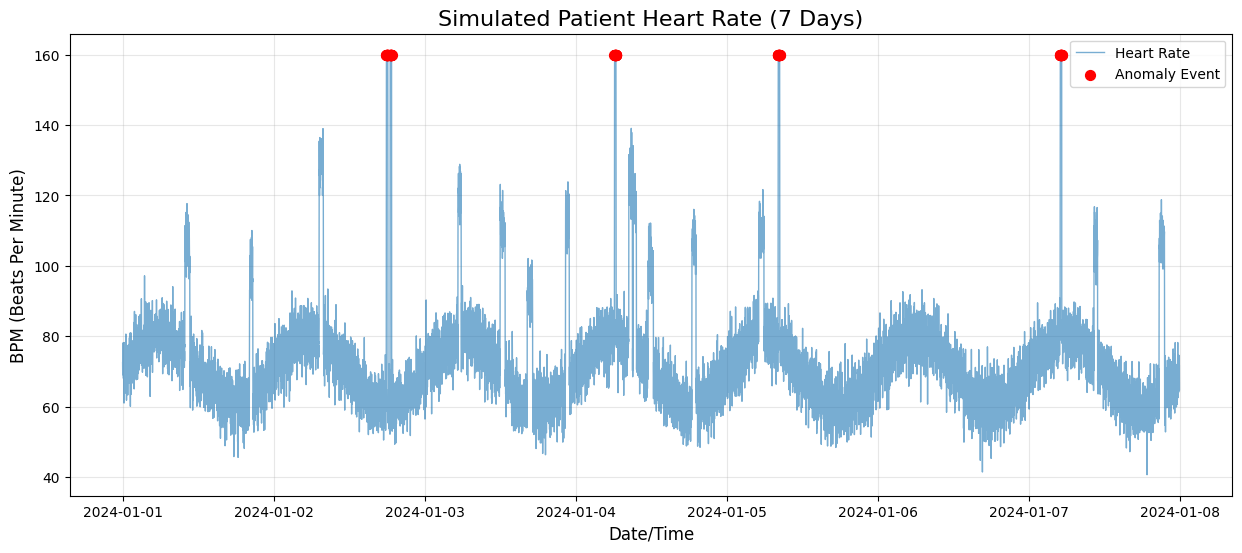

In [2]:
# Visualization
plt.figure(figsize=(15, 6))

# Plot the heart rate
plt.plot(df['Timestamp'], df['Heart_Rate'], label='Heart Rate', color='#1f77b4', alpha=0.6, linewidth=1)

# Highlight Anomalies
anomalies = df[df['Label'] == 1]
plt.scatter(anomalies['Timestamp'], anomalies['Heart_Rate'], color='red', label='Anomaly Event', s=50, zorder=5)

plt.title('Simulated Patient Heart Rate (7 Days)', fontsize=16)
plt.ylabel('BPM (Beats Per Minute)', fontsize=12)
plt.xlabel('Date/Time', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

**Part 3: Feature Engineering (The Sliding Window)**

This is the most critical architectural decision.

The Problem: A standard regression model looks at a single row: Time: 10:00 AM, BPM: 110. Is this bad? We don't know.
The Solution: An LSTM looks at a Sequence. Time: 9:00 AM - 10:00 AM.

If the last 60 minutes showed steady activity (Jogging), 110 BPM is fine.
If the last 60 minutes showed deep sleep, 110 BPM is an anomaly.

We will convert our data into Sliding Windows:



*   Input (X): The past 60 minutes of data.
*   Target (y): The prediction for the next minute (or the anomaly label for the next minute).

Note: LSTMs are sensitive to scale. We must Normalize data to 0-1 range.



In [3]:
import torch
from sklearn.preprocessing import MinMaxScaler

# 1. Load & Extract Data
raw_data = df['Heart_Rate'].values.reshape(-1, 1)

# 2. Normalization
# LSTMs converge faster when data is between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

def create_sequences(data, seq_length):
    """
    Transforms a list of values into a list of sequences.
    Input: [10, 20, 30, 40, 50], seq_length=3
    Output X: [[10, 20, 30], [20, 30, 40]]
    Output y: [40, 50]
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# HYPERPARAMETER: Sequence Length
# How far back should the model look? 60 minutes seems reasonable.
SEQ_LENGTH = 60

# Create Tensors
X, y = create_sequences(scaled_data, SEQ_LENGTH)

print(f"Original Data Points: {len(scaled_data)}")
print(f"Sequences Created: {len(X)}")
print(f"Shape of X (Samples, Sequence Length, Features): {X.shape}")

Original Data Points: 10080
Sequences Created: 10020
Shape of X (Samples, Sequence Length, Features): (10020, 60, 1)


**Part 4: Tensor Preparation for PyTorch**

Time-series data has a strict requirement: Do Not Shuffle.
In Image classification, we shuffle data to remove bias. In Time Series, the order is the feature itself. If you shuffle, you destroy the timeline.

We will split the data chronologically:



*   First 80% = Training Set (Learn the user's normal habits).
*   Last 20% = Testing Set (Detect anomalies on unseen future days).



In [4]:
# 1. Split Train/Test Chronologically
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 2. Convert to PyTorch Tensors
# PyTorch layers expect FloatTensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# 3. Engineering Checkpoint
print("--- Engineering Checkpoint ---")
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape:  {X_test.shape}")
print("\nSample Sequence (First item in X_train):")
print(f"This tensor contains {X_train[0].shape[0]} minutes of history.")
print(f"It is used to predict the value: {y_train[0].item():.4f}")

--- Engineering Checkpoint ---
Training Data Shape: torch.Size([8016, 60, 1])
Testing Data Shape:  torch.Size([2004, 60, 1])

Sample Sequence (First item in X_train):
This tensor contains 60 minutes of history.
It is used to predict the value: 0.2476


**Summary of Phase 1**

We have successfully built the foundation for the Anomaly Detection Engine:



1.   Patient Data: We have 10,080 minutes of physiological data.
2.   Contextual Awareness: We created SEQ_LENGTH=60 windows, meaning our model will never judge a heart rate in isolation; it will always judge it based on the previous hour of context.
3.   Tensors Ready: The data is scaled (0-1), sequenced, split chronologically, and converted to PyTorch FloatTensors.



# **🧠 Project HeartGuard: Phase 2 - The LSTM Brain**

**From Pattern Matching to Context Awareness**

Objective: We have our prepared tensors (X_train, X_test). Now we will build the "Brain."

**The Engineering Logic:**

We are building a Regression LSTM.


*   Classification: Outputs a category (e.g., "Cat" or "Dog").
*   Regression: Outputs a specific value (e.g., "Expected Heart Rate: 72 BPM").

**The Anomaly Detection Strategy:**

We do not train the model to output "Anomaly." We train it to output "Normalcy."



1.   The model predicts the next minute's heart rate based on the last 60 minutes.
2.   If Model predicts 72 BPM and Sensor reads 75 BPM -> Error is Low (Green Light).
3.   If Model predicts 72 BPM and Sensor reads 160 BPM -> Error is Huge.
4.   That Huge Error is our Anomaly Signal.





**Part 1: The Univariate LSTM Architecture**

We define a PyTorch LSTM that takes a sequence of 60 minutes and outputs 1 prediction.

--- Starting LSTM Training ---
Epoch [5/20], Loss: 0.015672
Epoch [10/20], Loss: 0.023385
Epoch [15/20], Loss: 0.014666
Epoch [20/20], Loss: 0.011945
Training Complete.


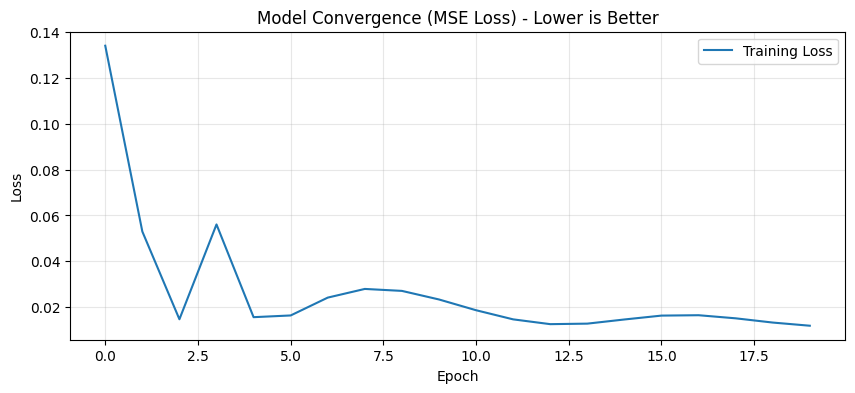

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. MODEL DEFINITION
# ==========================================
class HealthLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(HealthLSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM Layer
        # batch_first=True means input format is (Batch, Sequence Length, Features)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Fully Connected Layer (Decoder)
        # Maps the hidden state (50 features) to the single output value (Heart Rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)

        # Initialize hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # We only care about the hidden state of the LAST time step to make our prediction
        # out[:, -1, :] gets the last sequence step for the whole batch
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the Model
model = HealthLSTM()
criterion = nn.MSELoss() # Mean Squared Error (Standard for regression)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ==========================================
# 2. TRAINING LOOP
# ==========================================
print("--- Starting LSTM Training ---")
EPOCHS = 20 # Kept short for demonstration

model.train()
loss_history = []

for epoch in range(EPOCHS):
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(X_train)

    # Calculate Loss (Prediction vs Reality)
    loss = criterion(outputs, y_train)

    # Backward Pass (Backpropagation)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.6f}")

print("Training Complete.")

# Plot Training Convergence
plt.figure(figsize=(10,4))
plt.plot(loss_history, label='Training Loss')
plt.title("Model Convergence (MSE Loss) - Lower is Better")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Part 2: The Evaluation (Detecting the Anomalies)**

Now we simulate the "Real-Time Monitoring." We feed the Test Set (which contains the artificial spikes we injected in Phase 1) into the model.

**Visualizing the Result:**



*   Green Line (AI): What a healthy heart should be doing.
*   Blue Line (Sensor): What the heart is doing.
*   Red Dot: When the difference is too large.




--- Evaluation Report ---
Total Test Data Points: 2004
Anomalies Detected: 122


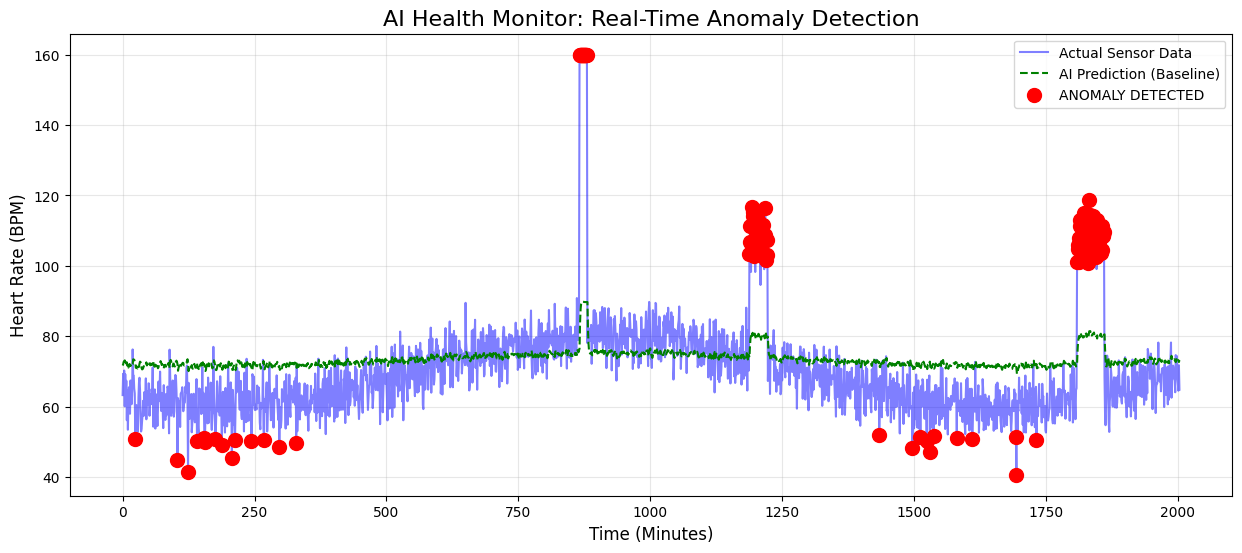

In [6]:
# ==========================================
# 3. EVALUATION & ANOMALY DETECTION
# ==========================================
model.eval()

with torch.no_grad():
    # Make predictions on the Test Set
    test_predictions = model(X_test)

    # Inverse Transform: Convert scaled 0-1 values back to BPM
    predicted_bpm = scaler.inverse_transform(test_predictions.numpy())
    actual_bpm = scaler.inverse_transform(y_test.numpy())

# Calculate the Absolute Error (The "Anomaly Score")
errors = np.abs(actual_bpm - predicted_bpm)

# Define a Threshold
# If the AI predicts 70 and sensor says 91, difference is 21. That's an anomaly.
THRESHOLD = 20

# Identify indices where error exceeds threshold
anomaly_indices = np.where(errors > THRESHOLD)[0]

print(f"\n--- Evaluation Report ---")
print(f"Total Test Data Points: {len(actual_bpm)}")
print(f"Anomalies Detected: {len(anomaly_indices)}")

# ==========================================
# 4. VISUALIZATION (The "App View")
# ==========================================
plt.figure(figsize=(15, 6))

# Plot Actual Heart Rate
plt.plot(actual_bpm, label='Actual Sensor Data', color='blue', alpha=0.5)

# Plot Model Prediction (Baseline)
plt.plot(predicted_bpm, label='AI Prediction (Baseline)', color='green', linestyle='--', linewidth=1.5)

# Highlight the Anomalies
if len(anomaly_indices) > 0:
    plt.scatter(anomaly_indices, actual_bpm[anomaly_indices], color='red', s=100, label='ANOMALY DETECTED', zorder=5)

plt.title('AI Health Monitor: Real-Time Anomaly Detection', fontsize=16)
plt.xlabel('Time (Minutes)', fontsize=12)
plt.ylabel('Heart Rate (BPM)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Part 3: The Upgrade - Context Awareness (Multivariate LSTM)**

**The Engineering Problem:**

The previous model is a "Pattern Matcher." It assumes high heart rate is bad if it hasn't seen it recently.
However, Context is King.



*   Heart Rate 140 is Normal if Activity = Running.
*   Heart Rate 140 is Critical if Activity = Sitting.




**3.1 Generating Context-Aware Data**

We need to generate a new dataset where Activity and Heart Rate are mathematically correlated.

In [7]:
# ==========================================
# 1. GENERATE CONTEXTUAL DATA
# ==========================================
def generate_context_data(days=7):
    minutes = days * 24 * 60

    # Generate Activity (0 = Sit, 1 = Walk, 2 = Run)
    # Weighted probabilities: Mostly sitting
    activity = np.random.choice([0, 0, 0, 0, 1, 2], size=minutes, p=[0.8, 0.05, 0.05, 0.05, 0.03, 0.02])

    # Generate Heart Rate BASED on Activity
    base_hr = 65
    activity_impact = activity * 40 # 0->0 boost, 1->40 boost, 2->80 boost
    noise = np.random.normal(0, 3, minutes)

    heart_rate = base_hr + activity_impact + noise

    # Inject Contextual Anomalies (High HR while Sitting)
    # Scenario: Activity is 0, but HR spikes to 160
    indices = np.random.choice(range(100, minutes-100), 5)
    for idx in indices:
        activity[idx:idx+20] = 0     # Sitting
        heart_rate[idx:idx+20] = 160 # PANIC

    df = pd.DataFrame({'Heart_Rate': heart_rate, 'Activity': activity})
    return df

df_multi = generate_context_data()

# ==========================================
# 2. PREPROCESSING (Dual Feature Scaling)
# ==========================================
# We fit on BOTH columns. Model sees [Scaled_HR, Scaled_Activity]
scaler_multi = MinMaxScaler()
scaled_data_multi = scaler_multi.fit_transform(df_multi[['Heart_Rate', 'Activity']].values)

SEQ_LENGTH = 60

def create_multivariate_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        # Input: 60 minutes of (HR, Activity) -> Shape (60, 2)
        x = data[i:(i + seq_length)]
        # Target: Next minute's HR (Column 0 only) -> Shape (1)
        y = data[i + seq_length][0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_m, y_m = create_multivariate_sequences(scaled_data_multi, SEQ_LENGTH)

# Split and Convert to Tensor
train_size_m = int(len(X_m) * 0.8)
X_train_m = torch.from_numpy(X_m[:train_size_m]).float()
y_train_m = torch.from_numpy(y_m[:train_size_m]).float()

print(f"Multivariate Input Shape: {X_train_m.shape}")
# Expected: [Samples, 60, 2] -> The '2' indicates HR + Activity

Multivariate Input Shape: torch.Size([8016, 60, 2])


**3.2 Updating the LSTM Architecture**

In [8]:
# Instantiate Model with Input Size = 2
model_v2 = HealthLSTM(input_size=2, hidden_size=50, output_size=1)
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.01)

print("--- Training Multivariate Model ---")
for epoch in range(15):
    optimizer_v2.zero_grad()
    outputs = model_v2(X_train_m)
    loss = criterion(outputs, y_train_m.unsqueeze(1)) # Ensure shape match
    loss.backward()
    optimizer_v2.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")

print("Context-Aware Model Trained.")

--- Training Multivariate Model ---
Epoch 5, Loss: 0.02851
Epoch 10, Loss: 0.02530
Epoch 15, Loss: 0.02245
Context-Aware Model Trained.


**Part 4: Deployment Preparation (MLOps)**

To use this in an app (FastAPI/Azure), we must save the "Brain" (Weights) and the "Translator" (Scaler). If we lose the scaler, the API won't know that "150 BPM" equals "0.8".



In [9]:
import joblib

# 1. Save the Model Weights
torch.save(model_v2.state_dict(), 'health_model_v2.pth')

# 2. Save the Scaler (Crucial!)
joblib.dump(scaler_multi, 'health_scaler.pkl')

print("Artifacts Saved Successfully:")
print("1. health_model_v2.pth (The Brain)")
print("2. health_scaler.pkl (The Translator)")

Artifacts Saved Successfully:
1. health_model_v2.pth (The Brain)
2. health_scaler.pkl (The Translator)
